# Preliminary processing

In [178]:
import pandas as pd
from datetime import datetime

weather_data_filepath = "data/weather_data.csv"
electricity_data_filepath = "data/electricity_production_data.csv"

df_weather = pd.read_csv(weather_data_filepath, delimiter=',')
df_electricity = pd.read_csv(electricity_data_filepath, delimiter=',')

df_weather['time'] = pd.to_datetime(df_weather['referenceTime'])
df_weather['time'] = df_weather['time'].dt.tz_localize(None)
print(df_weather['time'].info())
df_electricity['time'] = pd.to_datetime(df_electricity['måned'], format='%YM%m')
df_weather = df_weather.drop(columns="referenceTime")
df_electricity = df_electricity.drop(columns="måned")

df_weather['month_year'] = df_weather['time'].dt.strftime('%Y-%m')
df_electricity['month_year'] = df_electricity['time'].dt.strftime('%Y-%m')

<class 'pandas.core.series.Series'>
RangeIndex: 822 entries, 0 to 821
Series name: time
Non-Null Count  Dtype         
--------------  -----         
822 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.6 KB
None


In [179]:
df_weather.head()

,value,time,month_year
0,16.5,1950-12-31 23:00:00,1950-12
1,7.9,1951-01-31 23:00:00,1951-01
2,36.8,1951-02-28 23:00:00,1951-02
3,35.4,1951-03-31 23:00:00,1951-03
4,29.0,1951-04-30 23:00:00,1951-04


In [180]:
df_electricity.head()

,value,time,month_year
0,698737,1993-01-01,1993-01
1,654965,1993-02-01,1993-02
2,673560,1993-03-01,1993-03
3,488486,1993-04-01,1993-04
4,465860,1993-05-01,1993-05


In [181]:
df_merged = pd.merge(df_weather.drop(columns="time"), df_electricity.drop(columns="time"), on="month_year", suffixes=["_precipitation", "_electricity"], how="outer")
df_merged.sort_values(by='month_year', inplace=True)
df_merged.head()

,value_precipitation,month_year,value_electricity
0,16.5,1950-12,NaN
1,7.9,1951-01,NaN
2,36.8,1951-02,NaN
3,35.4,1951-03,NaN
4,29.0,1951-04,NaN


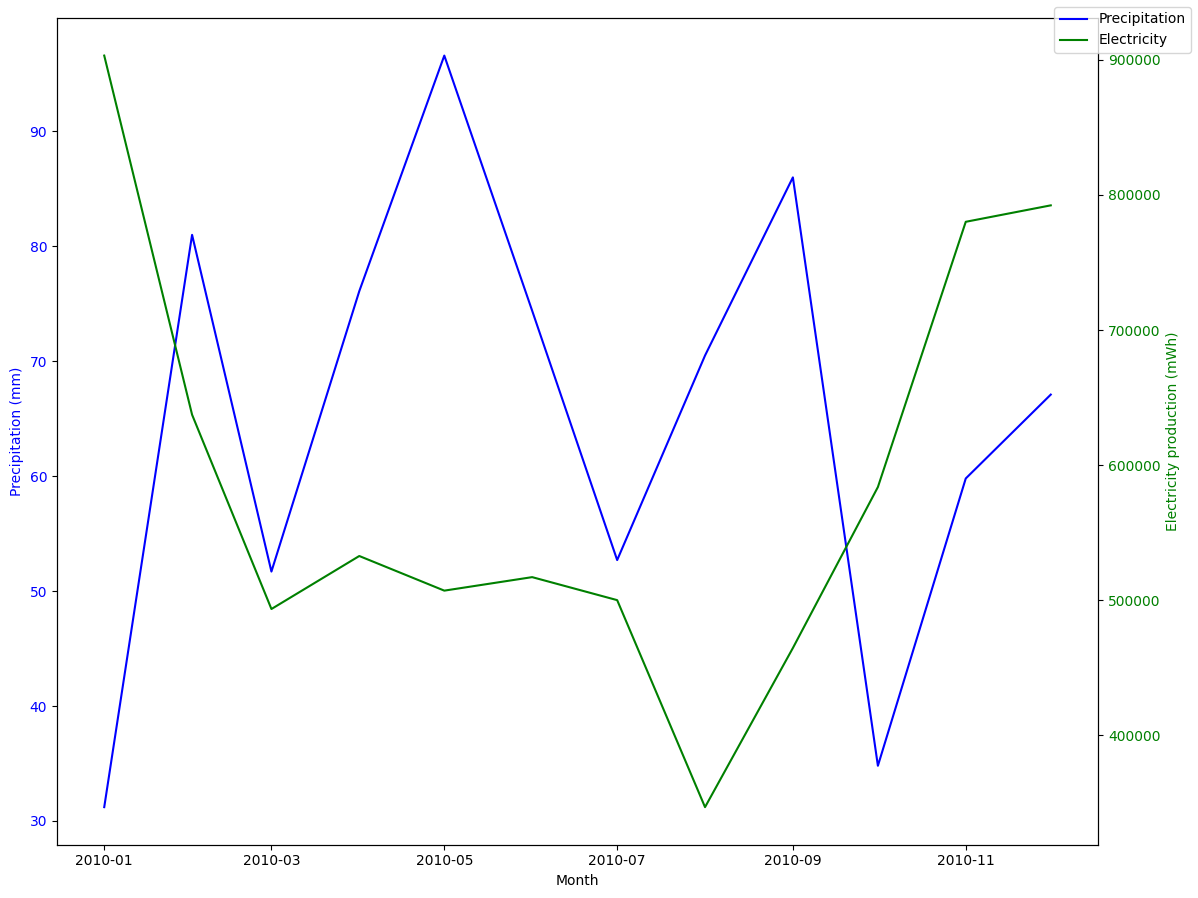

In [221]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,9))
start_year = 2010
stop_year = 2010
df_merged['month_year'] = pd.to_datetime(df_merged['month_year'], format='%Y-%m')
cropped_df_merged = df_merged[(df_merged['month_year'].dt.year >= start_year) & (df_merged['month_year'].dt.year <= stop_year)]

ax1.plot(cropped_df_merged['month_year'], cropped_df_merged['value_precipitation'], color="blue", label="Precipitation")
ax1.set_xlabel('Month')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(cropped_df_merged['month_year'], cropped_df_merged['value_electricity'], color="green", label="Electricity")
ax2.set_ylabel('Electricity production (mWh)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
fig.legend()
plt.show()

In [183]:
df_merged_all_values = df_merged.dropna()
df_merged_all_values.head()

df_merged_all_values.set_index('month_year', inplace=True)

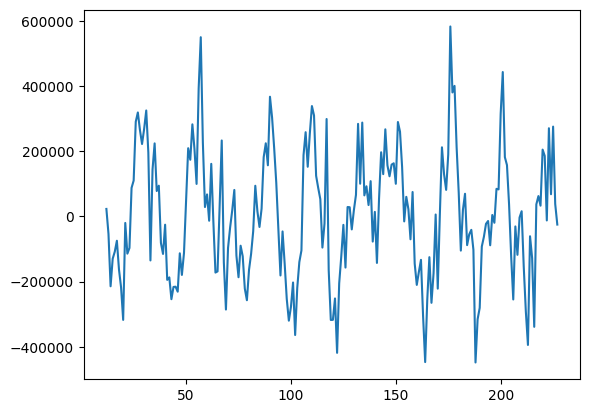

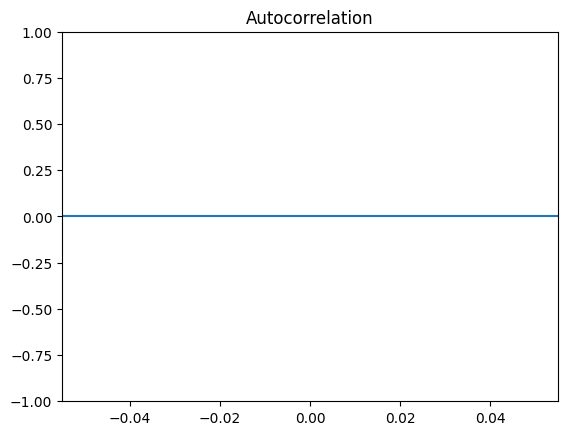

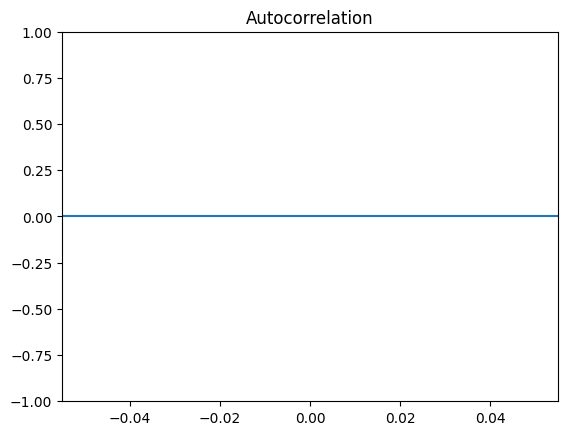

In [224]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

differenced_electricity = df_electricity['value'].diff(12)
plt.plot(differenced_electricity)
plt.show()
plot_acf(differenced_electricity, lags=40, ax=plt.gca())

# Modeling

## Import model

In [261]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_merged_all_values['value_electricity'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -5.292371473759111
p-value: 5.6784412662913794e-06
Critical Values:
   1%: -3.461429147102264
   5%: -2.875206950587861
   10%: -2.5740544497344002


/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Max

                               SARIMAX Results                                
Dep. Variable:      value_electricity   No. Observations:                  228
Model:               ARIMA(12, 1, 12)   Log Likelihood               -2928.986
Date:                Fri, 15 Nov 2024   AIC                           5907.971
Time:                        09:26:20   BIC                           5993.595
Sample:                    01-01-1993   HQIC                          5942.522
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3316      0.209     -1.590      0.112      -0.740       0.077
ar.L2         -0.2737      0.237     -1.155      0.248      -0.738       0.191
ar.L3         -0.4018      0.198     -2.031      0.0

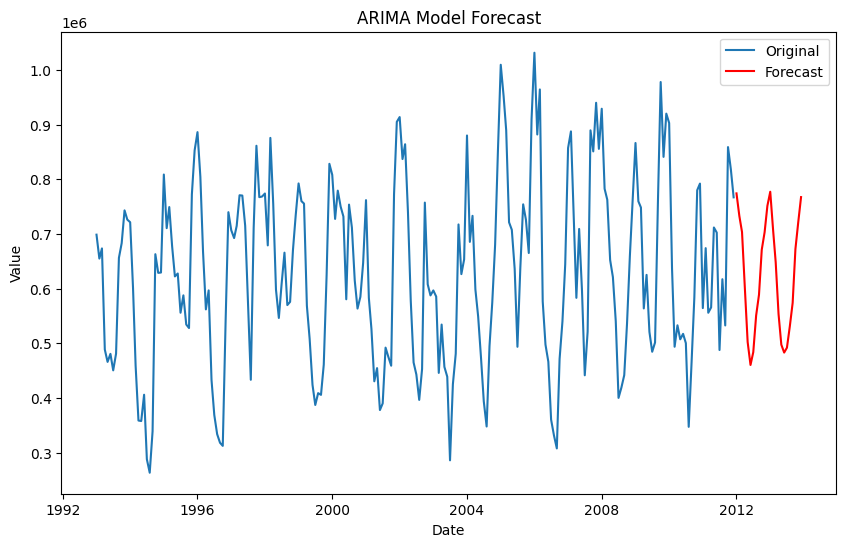

In [262]:
model = ARIMA(df_merged_all_values['value_electricity'], order=(12, 1, 12))  # Adjust the order (p, d, q) as needed
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions
forecast = model_fit.forecast(steps=24)  # Forecast the next 12 months
print(forecast)

# Plot the original series and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_merged_all_values['value_electricity'], label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [280]:
model = ARIMA(df_merged_all_values['value_electricity'], order=(2,0,2), exog=df_merged_all_values['value_precipitation'])

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      value_electricity   No. Observations:                  228
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2956.347
Date:                Fri, 15 Nov 2024   AIC                           5926.694
Time:                        09:41:39   BIC                           5950.699
Sample:                    01-01-1993   HQIC                          5936.379
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.913e+05   1.72e+04     40.167      0.000    6.58e+05    7.25e+05
value_precipitation  -894.4353    160.984     -5.556      0.000   -1209.958    -578.913
ar.L1           

/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


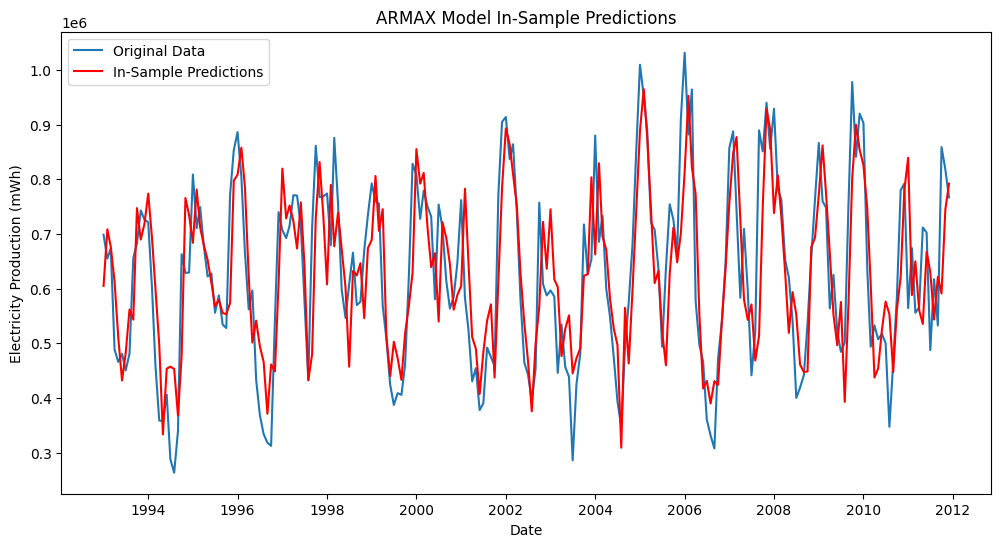

In [286]:
# Get in-sample predictions
in_sample_predictions = model_fit.predict(start=0, end=len(df_merged_all_values)-1, dynamic=False)
residuals = pd.DataFrame(model_fit.resid)
# Plot the original data and the in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(df_merged_all_values['value_electricity'], label='Original Data')
plt.plot(in_sample_predictions, label='In-Sample Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Production (mWh)')
plt.title('ARMAX Model In-Sample Predictions')
plt.legend()
plt.show()

                   0
count     228.000000
mean       92.484350
std    103574.040300
min   -275120.221356
25%    -70680.376117
50%    -11640.602995
75%     67375.854491
max    376080.066939


<Axes: ylabel='Density'>

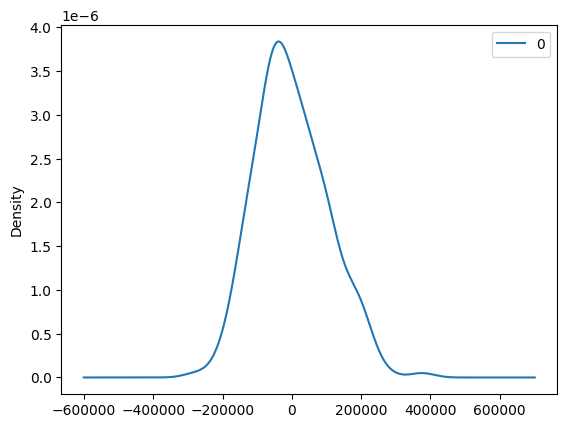

In [291]:
print(residuals.describe())

residuals.plot(kind="kde")

## Own model

### Differencing

In [148]:
import numpy as np

# def difference(df: pd.DataFrame, column: str, lag=1):
#     series = df[column]
#     differenced_series = [series.iloc[i] - series.iloc[i-lag] for i in range(lag, len(series))]
#     return np.array(differenced_series)

# diff_series = difference(df_merged_all_values, "value_electricity")
# df_merged_all_values['value_electricity_differenced'] = difference(df_merged_all_values, "value_electricity")

def apply_differencing(df: pd.DataFrame, column: str, d=1, D=1, season_period=12):
    diff_data = df[column].copy()
    for _ in range(d):
        diff_data = diff_data.diff().dropna()

    for _ in range(D):
        diff_data = diff_data.diff(periods=season_period).dropna()

    return diff_data

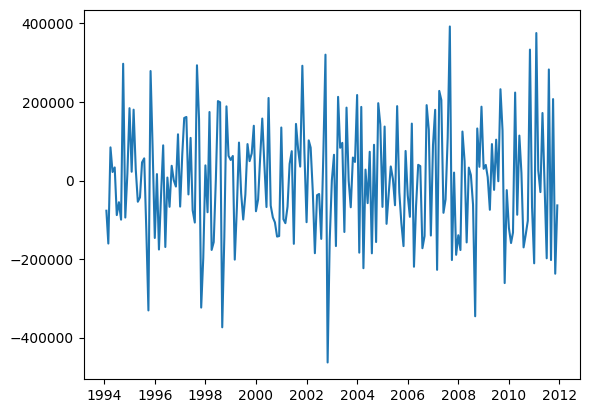

In [149]:
df = df_merged_all_values

diff_data = apply_differencing(df, column='value_electricity', d=1, D=1, season_period=12)

plt.plot(diff_data)
plt.show()

### Autoregressive

In [150]:
def compute_ar_term(data: pd.DataFrame, ar_params, p):
    ar_term = pd.Series(0, index=data.index)
    for t in range(p, len(data)):
        ar_term.iloc[t] = sum(ar_params[i]*data.iloc[t-i-1] for i in range(p))
    return ar_term

### Moving average

In [151]:
def compute_ma_term(errors: pd.DataFrame, ma_params, q):
    ma_term = pd.Series(0, index=errors.index)
    for t in range(q, len(errors)):
        ma_term.iloc[t] = sum(ma_params[i]*errors.iloc[t-i-1] for i in range(q))
    return ma_term

### Residuals

In [162]:
def calculate_residuals(df: pd.DataFrame, mu, ar_params, ma_params, p, q):
    preds = pd.Series(0, index=df.index)
    errors = pd.Series(0, index=df.index)
    ar_term = compute_ar_term(df, ar_params, p)
    ma_term = compute_ma_term(df, ma_params, q)

    for t in range(max(p,q), len(df)):
        preds.iloc[t] = mu + ar_term.iloc[t] + ma_term.iloc[t]
        errors.iloc[t] = df.iloc[t]-preds.iloc[t]
    return preds, errors

def gradient_descent(df, column, p, q, lr, epochs):
    data = df['value_electricity']
    mu = np.mean(data)
    ar_params = np.random.normal(0, 0.1, p)
    ma_params = np.random.normal(0, 0.1, q)

    for epoch in range(epochs):
        predictions, errors = calculate_residuals(data, mu, ar_params, ma_params, p, q)
        loss = np.sum(errors**2)

        grad_mu = -2 * np.sum(errors) / len(errors)
        grad_ar_params = np.zeros(p)
        for i in range(p):
            grad_ar_params[i] = -2 * np.sum(errors[max(p, q):] * data.shift(i + 1).dropna()[max(p, q):])
        
        grad_ma_params = np.zeros(q)
        for i in range(q):
            grad_ma_params[i] = -2 * np.sum(errors[max(p, q):] * errors.shift(i + 1).dropna()[max(p, q):])

        mu -= lr*grad_mu
        ar_params -= lr * grad_ar_params
        ma_params -= lr * grad_ma_params


        print(f"Epoch {epoch}, Loss: {loss}")
    return mu, ar_params, ma_params
    

In [177]:
p = 4
q = 5

# Ensure diff_data contains only numeric values and drop NaNs
diff_data = diff_data.apply(pd.to_numeric, errors='coerce').dropna()

# Assume `df` is your DataFrame and 'value_electricity' is the target column
diff_data = pd.DataFrame(diff_data, columns=['value_electricity'])
mu, ar_params, ma_params = gradient_descent(diff_data, column='value_electricity', p=2, q=2, lr=0.001, epochs=500)
# diff_data.rename(columns={diff_data.columns[0]: 'value_electricity'}, inplace=True)



/var/folders/d7/j_29bjyn0_lbt66yfhsy0pf00000gp/T/ipykernel_73608/3091183468.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3542.019426994275' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ar_term.iloc[t] = sum(ar_params[i]*data.iloc[t-i-1] for i in range(p))
/var/folders/d7/j_29bjyn0_lbt66yfhsy0pf00000gp/T/ipykernel_73608/3640834342.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-37082.64750677371' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ma_term.iloc[t] = sum(ma_params[i]*errors.iloc[t-i-1] for i in range(q))
/var/folders/d7/j_29bjyn0_lbt66yfhsy0pf00000gp/T/ipykernel_73608/3323339584.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-33763

Epoch 0, Loss: 5139715467662.4
Epoch 1, Loss: 2.259431855899692e+32


ValueError: Invalid integer data type 'O'.

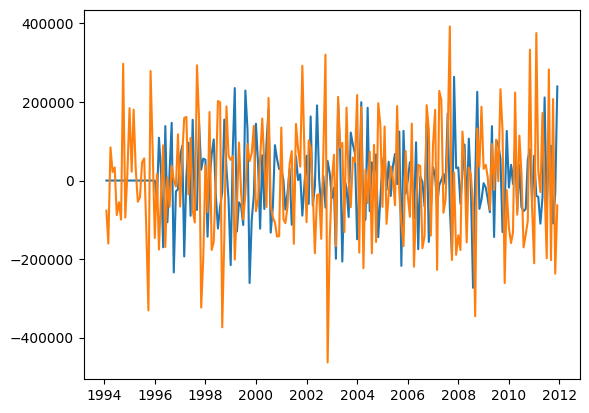

In [ ]:
plt.plot(predictions)
plt.plot(diff_data)